## Organisation of notebook

## Section 1: Background
- Introduction to problem objective
- Defining goals for our this section of our project

## Section 2: Data Scaping
- Scraping data from FBref, a comprehensive football statistic website

## Section 3: Data Preparation & Cleaning
- Cleaning the data scraped from Fbref and combining them with datasets obtained from Kaggle
- Includes adding one-hot encoded classification for variables like country of citizenship and playing position

## Section 4: Exploratory Data Analysis
- Analysing and visualising the data obtained using relevant plots 
- Discussing outliers and filtering them out

## Section 5: Data Pre-Processing
- Splitting data into train-test split
- Including MinMaxScaler for selected variables

## Section 6: Data Analysis Pipeline
- Training and testing our model on all 4 different machine learning models
- Analyzing the results and determining the best fit model for this situation

## Section 7: Model Application
- Using the preferred model to solve the problem statement of bringing in quality players at a reasonable price

## Section 8: Conclusion
- Summary of our journey and results from this section

# Section 1: Background

## Problem Statement

Manchester United's performances have nosedived since winning the league in 2012/13. Their lackluster performances can be attributed to a multitude of different factors but most importantly a poor transfer strategy. Deadwood players are being kept in the team while the club is buying overvaluing players and paying more than the results they produce. Hence, a **better transfer and player retention strategy is needed**.

## Goals

To craft a better player retention strategy, we decided to opt for a data science centric approach. In this notebook, we will be **developing multiple different machine learning and data science models** to predict the **current valuation of players**. With these prediction models, we aim to:

1. Determine suitable transfer prices for high performing players to let in via current player valuation predictions

2. Determine low-valued players to let go


# Section 2: Data Scraping

Data Sources:

1. Transfermarkt Player Valuation on Kaggle [link](https://www.kaggle.com/datasets/davidcariboo/player-scores)
2. FBref Player seasonal statistics [link](https://fbref.com/en/players/dea698d9/Cristiano-Ronaldo)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Imports and Directory Setup
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import math
from pathlib import Path
import os 
from datetime import datetime
import time
import re
import sys

# Edit this based on gdrive path
hx_directory = "/content/gdrive/MyDrive/Work 2023/SC1015/Player_Valuation"
ivan_directory = "/content/gdrive/MyDrive/SC1015/SC1015/Player_Valuation"

directory = hx_directory
# directory = ivan_directory

%cd {directory}

/content/gdrive/MyDrive/Work 2023/SC1015/Player_Valuation


## Section 2.1 Functions for scraping

This section contains the functions which will be used when scraping

In [ ]:
# function to give scrapped html from a url using BeautifulSoup4
def getSoup(url):  
  r = requests.get(url)
  soup = BeautifulSoup(r.content, 'html5lib')
  return soup

In [ ]:
# function to set first row of dataframe to headers
def changeheaders(df):
  newcols = []
  for i in range(0,len(df.columns)):
    newcols.append(df.columns[i][1])
  df.columns = newcols
  return df

In [ ]:
# function to get index for end of desired table
def stopindex(df):
  s= df["Age"].str.contains("Seasons")
  stop = s[s==True].index[0]
  return stop

In [ ]:
# function to create dataframe object from raw html and desired table
def maketable(soup,classtype,idname):
  result = soup.find(classtype,{"id":idname})
  if(result == None):
    return False
  df=pd.read_html(str(result))[0]
  df=changeheaders(df)
  stop =stopindex(df)
  df = df.iloc[:stop,:]
  return df

In [ ]:
# function to filter aerial stats from dataframe object
def makeAerialtable(aerialdf):
  if("Won" not in aerialdf.columns):
    return False
  aerialdf=aerialdf[["Season","Won","90s"]]
  aerialdf = aerialdf.loc[aerialdf["Won"]==(aerialdf["Won"])]
  aerialdf["Won"] = pd.to_numeric(aerialdf["Won"],errors="coerce")
  aerialdf["90s"] = pd.to_numeric(aerialdf["90s"],errors="coerce")
  aerialdf["Aerial_duels_per90"] = aerialdf["Won"]/aerialdf["90s"]
  aerialdf = aerialdf[["Season","Aerial_duels_per90"]]
  return aerialdf

In [ ]:
# function to retrieve height of a player from raw html
def getHeight(soup):
  foot = soup.find_all("p")
  for f in foot:
    if (f.find("span")):
      text = f.find("span").get_text()
      match = re.search(r'\d+cm', text)
      if match:
        return (match.group(0))

In [ ]:
# function to filter dataframe rows to only include seasons played in the EPL and add relevant stats together if there are multiple entries per season
def filterEPL(generalStats):
  generalStats = generalStats[generalStats["League"].str.contains("Premier League")]
  generalStats["Min"] = pd.to_numeric(generalStats["Min"],errors="coerce")
  generalStats["Goals_per90"] = pd.to_numeric(generalStats["Goals_per90"],errors="coerce")
  generalStats["Assists_per90"] = pd.to_numeric(generalStats["Assists_per90"],errors="coerce")
  temp=generalStats[["Season","Min","Goals_per90","Assists_per90"]].groupby(by=["Season"]).sum()
  temp.reset_index(inplace=True)
  generalStats.drop_duplicates(subset=["Season"],keep="last",inplace = True)
  generalStats.reset_index(drop=True,inplace=True)
  generalStats["Min"] = temp["Min"]
  generalStats["Assists_per90"] = temp["Assists_per90"]
  generalStats["Goals_per90"] = temp["Goals_per90"]
  return generalStats

In [ ]:
# function to filter general stats from a dataframe object
def makeGeneralStats(generalStats):
  assists_per90 = generalStats["Ast"].iloc[:,1:]
  goals_per90= generalStats["Gls"].iloc[:,1:]
  df2 = generalStats[["Season","Age","Min","Squad"]]
  name = soup.find("h1").get_text().strip()
  df2.insert(0,"Name",name)
  df2["Assists_per90"]=assists_per90
  df2["Goals_per90"]=goals_per90
  df2["Age"] = pd.to_numeric(df2["Age"],errors="coerce")
  df2['Age_Squared'] = df2["Age"].map(lambda a: a**2)
  height = getHeight(soup)
  df2.insert(4,"Height",height)
  position = soup.find("strong", string="Position:").next_sibling
  temp1 = position.split('\xa0▪')[0]
  print("TEMP 1 IS " + temp1)
  df2.insert(5,"Position",temp1)
  df2["League"] = generalStats["Comp"]
  return df2

In [ ]:
# function to get new url if previous url did not directly link to user profile page
def redirect(soup):
  soup.find_all('div', class_="search-item-name")[0]
  result = soup.find_all('div', class_="search-item-name")[0]
  anotherresult = result.find('a',href=True)
  return anotherresult['href']

## Section 2.2 Getting the list of players to scrape

This section gathers the list of players whose data will be scraped

In [ ]:
# reading csv file for player names with valuation
oldplayerdf = pd.read_csv("Data/players.csv")
oldplayerevaluationdf = pd.read_csv("Data/player_valuations.csv")

In [ ]:
# reading csv file for players who played in EPL from 2017-2022
eplplayers = pd.read_csv("Data/EPL Players(2017-2022).csv")

In [ ]:
# changing the series into lists
csvlist = oldplayerdf["name"].tolist()
eplplayers = eplplayers["Player Name"].tolist()

In [ ]:
# getting the interesecting names from both lists
common_list = set(csvlist).intersection(eplplayers)
common_list = list(common_list)


In [ ]:
kaijun_list=common_list[221:442]
ivan_list = common_list[1:10]
huixiang_list = common_list[442:]

## Section 2.3 Actual Scraping

This section will do the actual scraping and provide a final csv file which can be saved

In [ ]:
# loops through every name in the list and scraps the data from fbref and eventaully produce a dataframe with desired columns
counter = 0
error_names=[]
for name in ivan_list:
  try:
    print("*********************")
    print("CURRENT PLAYER IS "+ name)
    print("**********************")
    fbrefurl = "https://fbref.com/en/search/search.fcgi?hint=&search=" + name +"&pid=&idx="
    print(fbrefurl)
    soup=getSoup(fbrefurl)
    time.sleep(7)
    if(isinstance(maketable(soup,"table","stats_standard_dom_lg"),pd.DataFrame)):
      generalStats= maketable(soup,"table","stats_standard_dom_lg")
    elif(soup.find("strong", string="Position:")):
      continue
    else:
      newSoup=redirect(soup)
      soup = getSoup('https://fbref.com/'+newSoup)
      print('https://fbref.com/'+newSoup)
      time.sleep(7)
    generalStats = maketable(soup,"table","stats_standard_dom_lg")
    generalStats = makeGeneralStats(generalStats)
    generalStats = filterEPL(generalStats)
    aerialdf= maketable(soup,"table","stats_misc_dom_lg")
    aerialdf = makeAerialtable(aerialdf)
    aerialdf = aerialdf.groupby(by=["Season"]).sum()
    aerialdf.reset_index(inplace=True)
    if isinstance(aerialdf,pd.DataFrame):
      combined = aerialdf.merge(generalStats,how="inner",on="Season")
      combined = combined[["Season","Name","Age", "Age_Squared","Min","Height","Position","Aerial_duels_per90","Assists_per90","Goals_per90","League","Squad"]]
      if counter == 0:
        final = combined
        counter+=1
      else:
        final = pd.concat([final,combined])
  except KeyboardInterrupt:
    sys.exit()
    pass
  except Exception as e:
    print(e)
  except:
    print(name)
    error_names.append(name)
    pass

In [ ]:
final.to_csv('/Data/ivan_list.csv')

# Section 3: Data Preparation & Cleaning

## Section 3.1: Cleaning Player Stats Data

In this section, we clean the scraped data from FBref.com into a more trainable format.

In [ ]:
ivan = pd.read_csv("Data/ivan_list.csv", index_col=0)
hx = pd.read_csv("Data/hx_list.csv", index_col=0)
kaijun = pd.read_csv("Data/kaijun_list.csv", index_col=0)

In [ ]:
df = pd.concat([ivan, hx, kaijun])

In [ ]:
len(df)

1807

In [ ]:
median_fees = pd.read_csv("Data/median_transfer_fees.csv", index_col=0)
median_fees.head()

,Current Season,Club Name,Median Transfer Fee for previous 3 seasons (Euro Millions)
0,2017/2018,AFC Bournemouth,3.5
1,2017/2018,Arsenal FC,14.0
2,2017/2018,Aston Villa,3.8
3,2017/2018,Brighton & Hove Albion,0.4
4,2017/2018,Burnley FC,10.8


In [ ]:
club_mappings = {
    "Wolves": "Wolverhampton Wanderers",
    "Sheffield Utd": "Sheffield United",
    "Everton": "Everton FC",
    "Southampton": "Southampton FC",
    "West Brom": "West Bromwich Albion",
    "Arsenal": "Arsenal FC",
    "Fulham": "Fulham FC",
    "West Ham": "West Ham United",
    "Huddersfield": "Huddersfield Town",
    "Tottenham": "Tottenham Hotspur",
    "Watford": "Watford FC",
    "Newcastle Utd": "Newcastle United",
    "Chelsea": "Chelsea FC",
    "Manchester Utd": "Manchester United",
    "Liverpool": "Liverpool FC",
    "Bournemouth": "AFC Bournemouth",
    "Brighton": "Brighton & Hove Albion",
    "Burnley": "Burnley FC",
    "Brentford": "Brentford FC",
    "Nott'ham Forest": "Nottingham Forest"
}

In [ ]:
# Merging Median Transfer Fee & Player Season Stats Dataframes
df["Squad"] = df["Squad"].replace(club_mappings)
median_fees["Current Season"] = median_fees["Current Season"].str.replace("/", "-")
df = df.merge(median_fees, left_on=['Squad', 'Season'], right_on=['Club Name', 'Current Season'], how='left')

# Filling 0 million for clubs that did not make an outgoing transfer for a particular season
df["Median Transfer Fee for previous 3 seasons (Euro Millions)"] = df["Median Transfer Fee for previous 3 seasons (Euro Millions)"].fillna(0)

In [ ]:
position_mappings = {
    " DF-MF (DM-FB-WM, left)": "fullback",
    " MF (CM-DM-WM)": "centre midfield",
    " FW-MF (AM-WM)": "winger",
    " GK": "goalkeeper",
    " FW-MF (WM)": "striker",
    " DF-MF (FB, right)": "fullback",
    " FW": "striker",
    " DF-FW-MF (FB-WM, right)": "fullback",
    " DF-MF (FB-WM, right)": "fullback",
    " FW-MF": "striker",
    " DF-MF (CB-DM, right)": "centreback",
    " DF-FW-MF (AM-FB, left)": "fullback",
    " FW-MF (AM-WM, right)": "winger",
    " DF (CB)": "centreback",
    " DF-MF (CB-CM, left)": "centreback",
    " DF (FB, left)": "fullback",
    " MF (CM)": "centre midfield",
    " DF (CB, left)": "centreback",
    " DF-FW-MF": "winger",
    " DF-MF (FB, left)": "fullback",
    " MF (AM-CM-WM)": "centre midfield",
    " DF-MF (CM-DM-WM, left)": "centre midfield",
    " FW-MF (AM)": "winger",
    " DF-MF (CM-DM)": "central defensive midfield",
    " DF (CB-FB, left)": "centreback",
    " MF (AM-CM-DM-WM)": "centre midfield",
    " DF-MF (CB)": "centreback",
    " DF (FB, right)": "fullback",
    " DF-MF (CB-DM)": "centreback",
    " MF (AM)": "centre midfield",
    " DF-FW-MF (WM, left)": "side midfield",
    " DF (CB-FB)": "centreback",
    " DF-MF (CB, right)": "centreback",
    " FW-MF (WM, right)": "winger",
    " DF-MF": "fullback",
    " DF-MF (CM-DM, right)": "centre midfield",
    " MF": "centre midfield",
    " MF (CM-DM)": "central defensive midfield",
    " DF (CB-FB, right)": "centreback",
    " DF-MF (AM-WM, left)": "centre midfield",
    " DF-MF (CB-FB, right)": "fullback",
    " MF (AM-CM-DM)": "centre midfield",
    " DF-FW (FB, right)": "fullback",
    " MF (CM-WM, right)": "centre midfield",
    " DF-MF (CB-CM-DM)": "central defensive midfield",
    " MF (AM-CM, right)": "centre midfield",
    " FW-MF (WM, left)": "winger",
    " FW-MF (AM-CM-WM)": "centre midfield",
    " DF (CB, right)": "centreback",
    " FW-MF (AM, left)": "winger",
    " FW-MF (AM-WM, left)": "winger",
    " DF-MF (CB-FB, left)": "centreback",
    " DF-FW-MF (FB-WM)": "fullback",
    " MF (CM-WM)": "centre midfield",
    " DF-MF (CM-DM-FB-WM, right)": "centre midfield",
    " DF-FW-MF (FB)": "fullback",
    " FW-MF (AM-CM-DM)": "centre midfield",
    " MF (AM-WM)": "centre midfield",
    " DF-FW-MF (WM)": "side midfield",
    " DF-MF (FB-WM, left)": "fullback",
    " DF-MF (CM-FB-WM)": "centre midfield",
    " MF (CM, right)": "centre midfield",
    " DF-FW-MF (FB-WM, left)": "fullback",
    " DF-MF (DM-FB, left)": "fullback",
    " DF-MF (DM-FB, right)": "fullback",
    " MF (CM, left)": "centre midfield",
    " DF": "fullback",
    " FW-MF (AM-CM-DM, left)": "centre midfield",
    " DF-FW-MF (AM-DM-WM, right)": "side midfield",
    " MF (WM)": "centre midfield",
    " FW-MF (AM-CM, right)": "winger",
    " DF-MF (CB, left)": "centreback",
    " MF (DM)": "central defensive midfield",
    " FW-MF (CM-WM)": "centre midfield",
    " DF-MF (CM-DM-FB)": "central defensive midfield",
    " MF (DM, right)": "central defensive midfield",
    " FW-MF (CM)": "centre midfield",
    " DF-FW-MF (AM-WM)": "side midfield",
    " FW-MF (AM-CM)": "centre midfield",
    " DF-MF (CM)": "central defensive midfielder",
    " DF-FW-MF (AM, left)": "side midfield",
    " MF (AM-DM-WM)": "centre midfield",
    " DF-FW (CB, right)": "centreback",
    " MF (AM-CM-DM, right)": "centre midfield",
    " DF-MF (DM)": "central defensive midfielder",
    " DF-FW-MF (AM-CM-FB-WM)": "fullback",
    " DF (FB)": "fullback",
    " DF-MF (CB-FB-WM, left)": "centreback"
}

In [ ]:
# Simplifying Player Positions for easier training

df["Position"] = df["Position"].replace(position_mappings)
df["Position"] = df["Position"].astype("category")

## Section 3.2: Cleaning Player Valuation Data

In this section, we perform data cleaning on the player valuation data obtained from Kaggle & Transfermarkt.

In [ ]:
oldplayerdf = pd.read_csv("Data/players.csv")
oldplayerevaluationdf = pd.read_csv("Data/player_valuations.csv")

In [ ]:
oldplayerevaluationdf.sample(5)

,date,datetime,dateweek,player_id,current_club_id,market_value_in_eur,player_club_domestic_competition_id
86682,4/6/2011,4/6/2011,30/5/2011,37977,126,1500000,TR1
207300,21/7/2009,21/7/2009,20/7/2009,57515,589,12000000,TR1
72256,12/5/2009,12/5/2009,11/5/2009,111191,1435,50000,NL1
152252,14/1/2015,14/1/2015,12/1/2015,24105,417,800000,FR1
45318,15/8/2016,15/8/2016,15/8/2016,187674,150,100000,ES1


In [ ]:
oldplayerdf = oldplayerdf.drop(["market_value_in_eur","highest_market_value_in_eur"],axis=1)
oldplayerdf = oldplayerdf[oldplayerdf['current_club_domestic_competition_id'] == "GB1"]
oldplayerdf.head()

,player_id,name,current_club_id,current_club_name,country_of_citizenship,country_of_birth,city_of_birth,date_of_birth,position,sub_position,...,height_in_cm,agent_name,contract_expiration_date,current_club_domestic_competition_id,first_name,last_name,player_code,image_url,last_season,url
10,39049,Kei Kamara,1123,Norwich City,Sierra Leone,Sierra Leone,Kenema,1/9/1984,Attack,Centre-Forward,...,188,PROSPORT Management,31/12/2023,GB1,Kei,Kamara,kei-kamara,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/kei-kamara/pro...
11,46154,Chris Martin,1123,Norwich City,Scotland,England,Beccles,4/11/1988,Attack,Centre-Forward,...,184,After Sports Consultancy,30/6/2023,GB1,Chris,Martin,chris-martin,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/chris-martin/p...
12,104725,Steve Morison,1123,Norwich City,Wales,England,London,29/8/1983,Attack,Centre-Forward,...,188,10Ten Football,NaN,GB1,Steve,Morison,steve-morison,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/steve-morison/...
13,30471,James Vaughan,1123,Norwich City,England,England,Birmingham,14/7/1988,Attack,Centre-Forward,...,181,Unique Sports Group,NaN,GB1,James,Vaughan,james-vaughan,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/james-vaughan/...
14,3666,Jason Roberts,1032,Fc Reading,Grenada,England,London,25/1/1978,Attack,Centre-Forward,...,185,First Artist Corporation Plc.,NaN,GB1,Jason,Roberts,jason-roberts,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/jason-roberts/...


In [ ]:
combined = oldplayerdf.merge(oldplayerevaluationdf,left_on="player_id",right_on="player_id")

In [ ]:
combined = combined[["name","date","current_club_name","country_of_citizenship","foot","market_value_in_eur","player_code"]]
combined.head()

,name,date,current_club_name,country_of_citizenship,foot,market_value_in_eur,player_code
0,Kei Kamara,6/8/2009,Norwich City,Sierra Leone,Right,175000,kei-kamara
1,Kei Kamara,9/2/2012,Norwich City,Sierra Leone,Right,500000,kei-kamara
2,Kei Kamara,18/9/2013,Norwich City,Sierra Leone,Right,700000,kei-kamara
3,Kei Kamara,8/1/2014,Norwich City,Sierra Leone,Right,800000,kei-kamara
4,Kei Kamara,1/3/2015,Norwich City,Sierra Leone,Right,600000,kei-kamara


In [ ]:
def getSeason(date):
  year = date[-4:]
  current_season = datetime.strptime(date,"%d/%m/%Y")
  previous = "1/7/" + year
  previous = datetime.strptime(previous, "%d/%m/%Y")
  if (current_season>previous):
    season = year + "-" + str(int(year)+1)
  else:
    season = str(int(year)-1) + "-" +year
  return season

In [ ]:
def getMonth(date):
  real_date = pd.to_datetime(date,format="%d/%m/%Y")
  real_month = real_date.dt.strftime("%m")
  return real_month

In [ ]:
def getYear(date):
  real_date = pd.to_datetime(date,format="%d/%m/%Y")
  real_year = real_date.dt.strftime("%Y")
  return real_year

In [ ]:
combined = combined.assign(month = getMonth(combined["date"]))
combined = combined.assign(year = getYear(combined["date"]))

In [ ]:
# Retrieving only seasons later than 2017, where aerial duels data were first made available

combined = combined[combined["year"] > "2017"]
combined

,name,date,current_club_name,country_of_citizenship,foot,market_value_in_eur,player_code,month,year
10,Kei Kamara,2/5/2018,Norwich City,Sierra Leone,Right,800000,kei-kamara,05,2018
11,Kei Kamara,15/12/2018,Norwich City,Sierra Leone,Right,800000,kei-kamara,12,2018
12,Kei Kamara,27/5/2019,Norwich City,Sierra Leone,Right,600000,kei-kamara,05,2019
13,Kei Kamara,30/11/2019,Norwich City,Sierra Leone,Right,600000,kei-kamara,11,2019
14,Kei Kamara,8/4/2020,Norwich City,Sierra Leone,Right,475000,kei-kamara,04,2020
...,...,...,...,...,...,...,...,...,...
29783,Carlos Alcaraz,6/9/2022,Fc Southampton,Argentina,Right,8500000,carlos-alcaraz,09,2022
29784,Carlos Alcaraz,26/10/2022,Fc Southampton,Argentina,Right,8500000,carlos-alcaraz,10,2022
29785,Carlos Alcaraz,16/3/2023,Fc Southampton,Argentina,Right,12000000,carlos-alcaraz,03,2023
29786,Juan Larios,15/9/2022,Fc Southampton,Spain,Left,5000000,juan-larios,09,2022


In [ ]:
combined["date"] = combined["date"].apply(getSeason)
combined.drop_duplicates(subset=["name","date"],keep="last",inplace=True)
combined.sample(5)

,name,date,current_club_name,country_of_citizenship,foot,market_value_in_eur,player_code,month,year
29241,N'Golo Kanté,2018-2019,Fc Chelsea,France,Right,100000000,ngolo-kante,06,2019
43,Chris Martin,2020-2021,Norwich City,Scotland,Right,1000000,chris-martin,06,2021
18612,Lee Grant,2020-2021,Manchester United,England,Right,250000,lee-grant,06,2021
20608,Pontus Jansson,2018-2019,Fc Brentford,Sweden,Right,6000000,pontus-jansson,06,2019
19544,Andros Townsend,2022-2023,Fc Everton,England,Left,2500000,andros-townsend,11,2022


In [ ]:
combined = combined.drop(["player_code","month","year"],axis=1)

## Section 3.3: Merging of valuation & stats dataframes

In [ ]:
finaldf = df.merge(combined,how="inner",left_on=["Season","Name"],right_on=["date","name"])
finaldf.sample(5)

,Season,Name,Age,Age_Squared,Min,Height,Position,Aerial_duels_per90,Assists_per90,Goals_per90,...,Squad,Current Season,Club Name,Median Transfer Fee for previous 3 seasons (Euro Millions),name,date,current_club_name,country_of_citizenship,foot,market_value_in_eur
404,2021-2022,Saïd Benrahma,25,625,2168.0,172cm,winger,0.414938,0.25,0.33,...,West Ham United,2021-2022,West Ham United,3.00,Saïd Benrahma,2021-2022,West Ham United,Algeria,Right,25000000
328,2021-2022,Martin Dúbravka,32,1024,2340.0,190cm,goalkeeper,0.153846,0.00,0.00,...,Newcastle United,2021-2022,Newcastle United,2.24,Martin Dúbravka,2021-2022,Newcastle United,Slovakia,Right,4000000
1083,2017-2018,Jack Butland,24,576,3150.0,193cm,goalkeeper,0.171429,0.00,0.00,...,Stoke City,2017-2018,Stoke City,3.35,Jack Butland,2017-2018,Manchester United,England,Right,22000000
946,2022-2023,Ruben Loftus-Cheek,26,676,1314.0,191cm,centre midfield,1.438356,0.00,0.00,...,Chelsea FC,2022-2023,Chelsea FC,11.30,Ruben Loftus-Cheek,2022-2023,Fc Chelsea,England,Right,25000000
1419,2018-2019,Miguel Britos,33,1089,185.0,188cm,centreback,2.380952,0.00,0.00,...,Watford FC,2018-2019,Watford FC,4.70,Miguel Britos,2018-2019,Fc Watford,Uruguay,Left,2000000


In [ ]:
# Converting player height into a numerical entry

finaldf["Height"] = finaldf["Height"].str.rstrip("cm")
finaldf["Height"] = finaldf["Height"].astype(float)
finaldf["market_value_in_eur"] = finaldf["market_value_in_eur"].astype(float)

In [ ]:
# Converting citizenship and foot into categorical variables

finaldf["country_of_citizenship"] = finaldf["country_of_citizenship"].astype("category")
finaldf["foot"] = finaldf["foot"].astype("category")

In [ ]:
# One hot encoding of Position, Citizenship and Foot data
finaldf = pd.get_dummies(finaldf, columns=['Position', 'country_of_citizenship', 'foot'])

In [ ]:
finaldf = finaldf.drop(columns=['date','League','Current Season','Club Name','name','current_club_name'])
finaldf = finaldf[finaldf['Season'].str[:4].astype(int) < 2021]

In [ ]:
finaldf.to_csv('Data/raw_list.csv')

In [ ]:
finaldf.columns

Index(['Season', 'Name', 'Age', 'Age_Squared', 'Min', 'Height',
       'Aerial_duels_per90', 'Assists_per90', 'Goals_per90', 'Squad',
       'Median Transfer Fee for previous 3 seasons (Euro Millions)',
       'market_value_in_eur', 'Position_central defensive midfield',
       'Position_central defensive midfielder', 'Position_centre midfield',
       'Position_centreback', 'Position_fullback', 'Position_goalkeeper',
       'Position_side midfield', 'Position_striker', 'Position_winger',
       'country_of_citizenship_Albania', 'country_of_citizenship_Algeria',
       'country_of_citizenship_Argentina', 'country_of_citizenship_Belgium',
       'country_of_citizenship_Brazil', 'country_of_citizenship_Burkina Faso',
       'country_of_citizenship_Canada', 'country_of_citizenship_Colombia',
       'country_of_citizenship_Cote d'Ivoire',
       'country_of_citizenship_Curacao', 'country_of_citizenship_DR Congo',
       'country_of_citizenship_Denmark',
       'country_of_citizenship_Domin

In [ ]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 0 to 1483
Data columns (total 73 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Season                                                      959 non-null    object 
 1   Name                                                        959 non-null    object 
 2   Age                                                         959 non-null    int64  
 3   Age_Squared                                                 959 non-null    int64  
 4   Min                                                         959 non-null    float64
 5   Height                                                      959 non-null    float64
 6   Aerial_duels_per90                                          959 non-null    float64
 7   Assists_per90                                               959 non-null    float64
 8  

# Section 4: Exploratory Data Analysis

In [ ]:
finaldf = pd.read_csv("Data/raw_list.csv", index_col=0)

Here we can see our some details about scapped data. With a total of 959 rows, we believe that this will be sufficient in training an accurate model to evaluate a player's valuation from their playing statistics. Most of the more essential statisics are listed at the front like age, minutes played and market value in Euros while the majority that cannot be seen in the output are just one hot encoded columns for the player's citizenship and playing position

In [ ]:
# Important metrics of our dataframe
finaldf.describe()

,Age,Age_Squared,Min,Height,Aerial_duels_per90,Assists_per90,Goals_per90,Median Transfer Fee for previous 3 seasons (Euro Millions),market_value_in_eur,Position_central defensive midfield,...,country_of_citizenship_Tunisia,country_of_citizenship_Ukraine,country_of_citizenship_United States,country_of_citizenship_Uruguay,country_of_citizenship_Venezuela,country_of_citizenship_Wales,country_of_citizenship_Zambia,foot_Both,foot_Left,foot_Right
count,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,9.590000e+02,959.000000,...,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.0,959.000000,959.000000,959.000000
mean,25.843587,683.593326,1774.831074,182.503650,2.115972,0.079906,0.110636,7.344630,1.648279e+07,0.066736,...,0.003128,0.012513,0.007299,0.002086,0.002086,0.019812,0.0,0.027112,0.216893,0.755996
std,3.964685,210.402903,973.884070,6.905698,2.398818,0.116048,0.157065,6.766272,1.779193e+07,0.249695,...,0.055872,0.111218,0.085168,0.045643,0.045643,0.139428,0.0,0.162493,0.412344,0.429719
min,17.000000,289.000000,0.000000,163.000000,0.000000,0.000000,0.000000,0.000000,2.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,23.000000,529.000000,951.500000,178.000000,0.722892,0.000000,0.000000,3.050000,5.000000e+06,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
50%,26.000000,676.000000,1758.000000,182.000000,1.552347,0.040000,0.060000,5.850000,1.000000e+07,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
75%,28.000000,784.000000,2606.000000,188.000000,2.912007,0.120000,0.150000,9.600000,2.200000e+07,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
max,39.000000,1521.000000,3420.000000,201.000000,33.192308,1.840000,1.340000,37.500000,1.400000e+08,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [ ]:
info = finaldf.describe()[["Age","Min","Height","Aerial_duels_per90","Goals_per90","Assists_per90","Median Transfer Fee for previous 3 seasons (Euro Millions)","market_value_in_eur"]]
info

,Age,Min,Height,Aerial_duels_per90,Goals_per90,Assists_per90,Median Transfer Fee for previous 3 seasons (Euro Millions),market_value_in_eur
count,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,9.590000e+02
mean,25.843587,1774.831074,182.503650,2.115972,0.110636,0.079906,7.344630,1.648279e+07
std,3.964685,973.884070,6.905698,2.398818,0.157065,0.116048,6.766272,1.779193e+07
min,17.000000,0.000000,163.000000,0.000000,0.000000,0.000000,0.000000,2.500000e+05
25%,23.000000,951.500000,178.000000,0.722892,0.000000,0.000000,3.050000,5.000000e+06
50%,26.000000,1758.000000,182.000000,1.552347,0.060000,0.040000,5.850000,1.000000e+07
75%,28.000000,2606.000000,188.000000,2.912007,0.150000,0.120000,9.600000,2.200000e+07
max,39.000000,3420.000000,201.000000,33.192308,1.340000,1.840000,37.500000,1.400000e+08


<ipython-input-87-82a6f5216d5a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(finaldf.corr())


<Axes: >

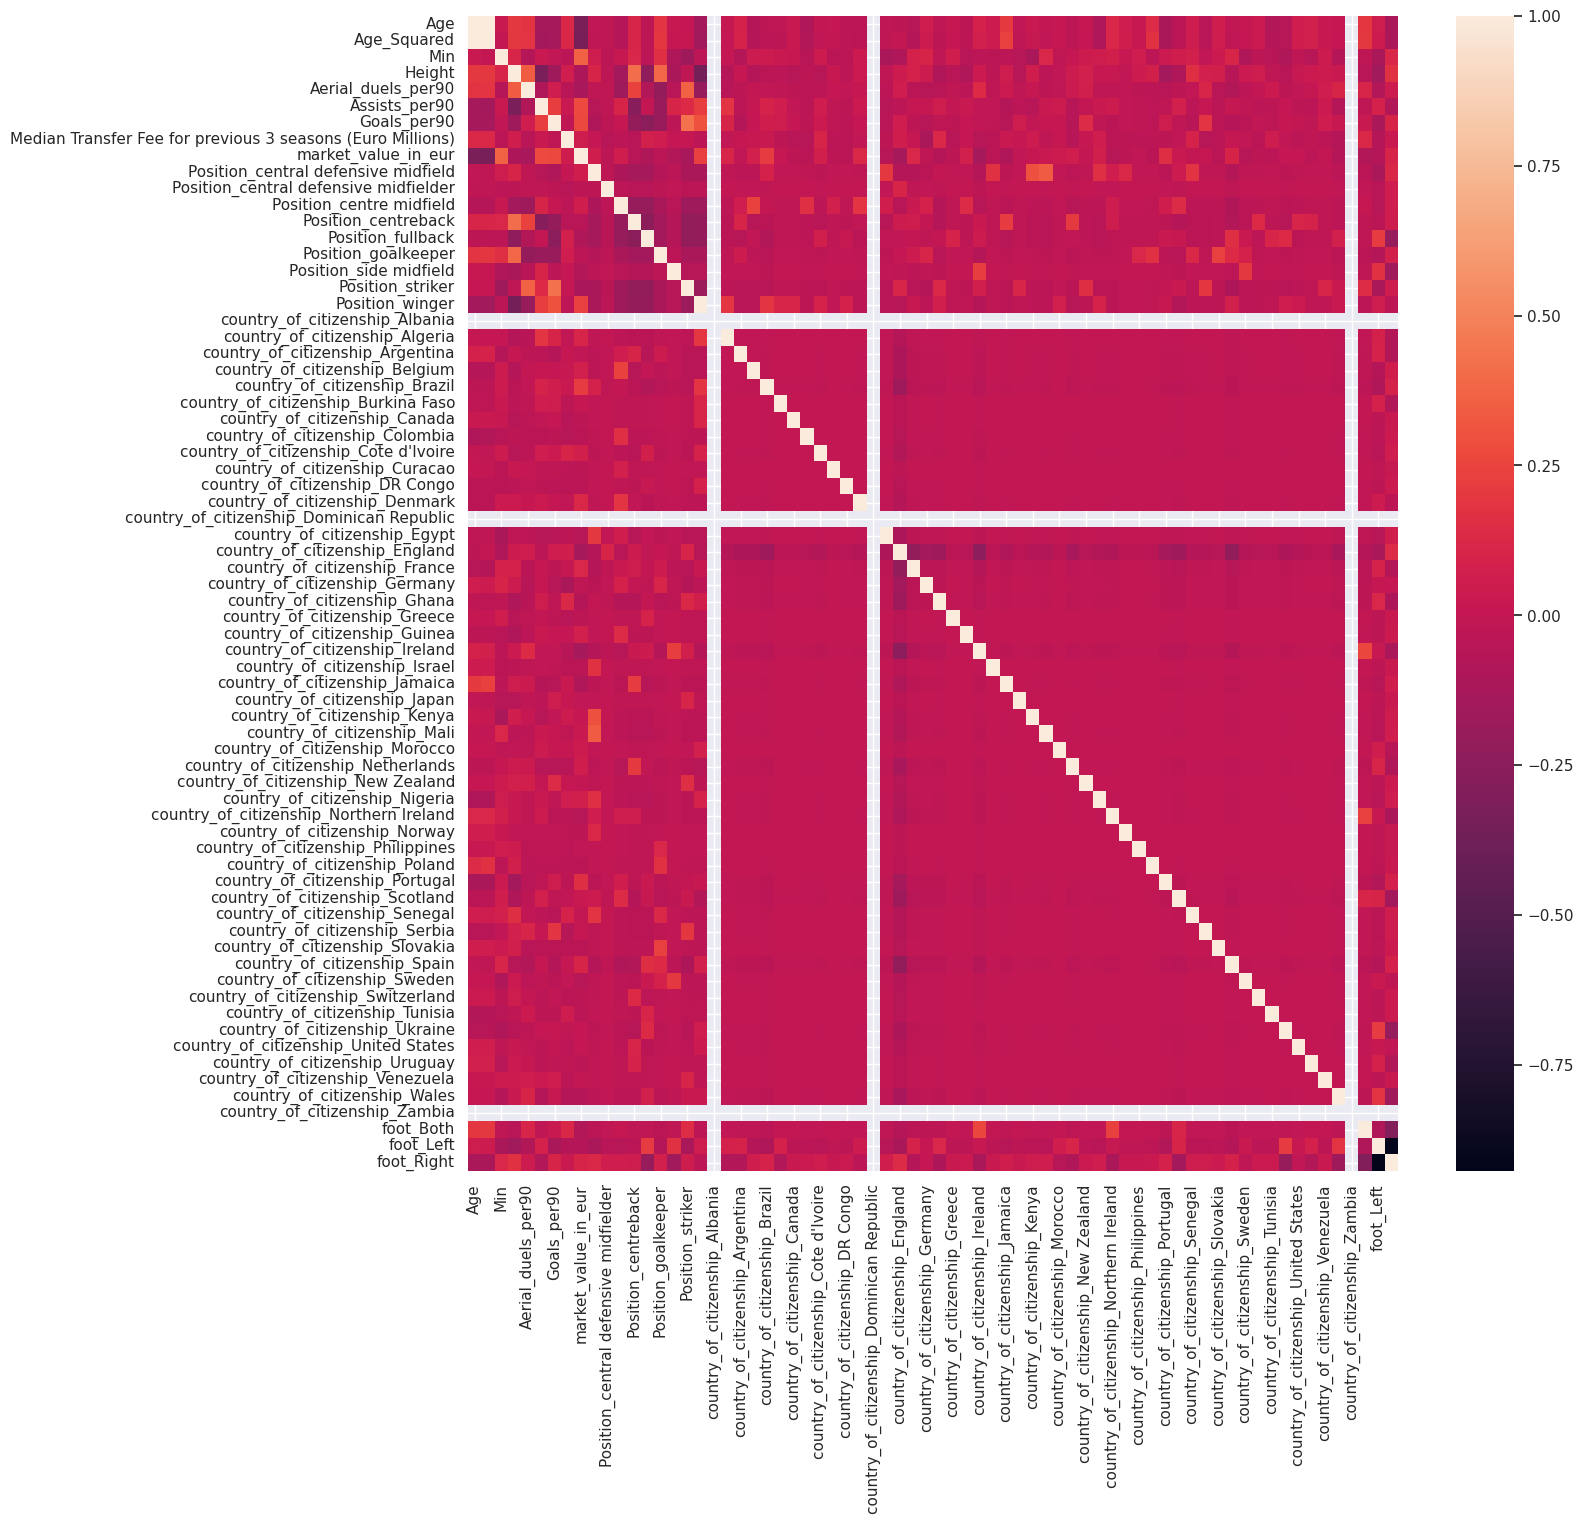

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(finaldf.corr())

 The next few cells are describing the correlation between different variables. The first cell below is the heatmap for all of our variables. Since we have quite a number of different variables, it may be a little hard to take the whole graph in at once and fully digest the information here. But as we can see the first large chunk of variables from age to positon played seems to have a darker shade of red which indicates a higher level of correlation. To investigate further, we will be plotting a bar graph to visualise the data easier.

In [ ]:
sns.set(rc={'figure.figsize':(8.4,4.8)})

<ipython-input-89-5e8060370700>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  finaldf.corr()["market_value_in_eur"][:30].plot(kind='bar')


<Axes: >

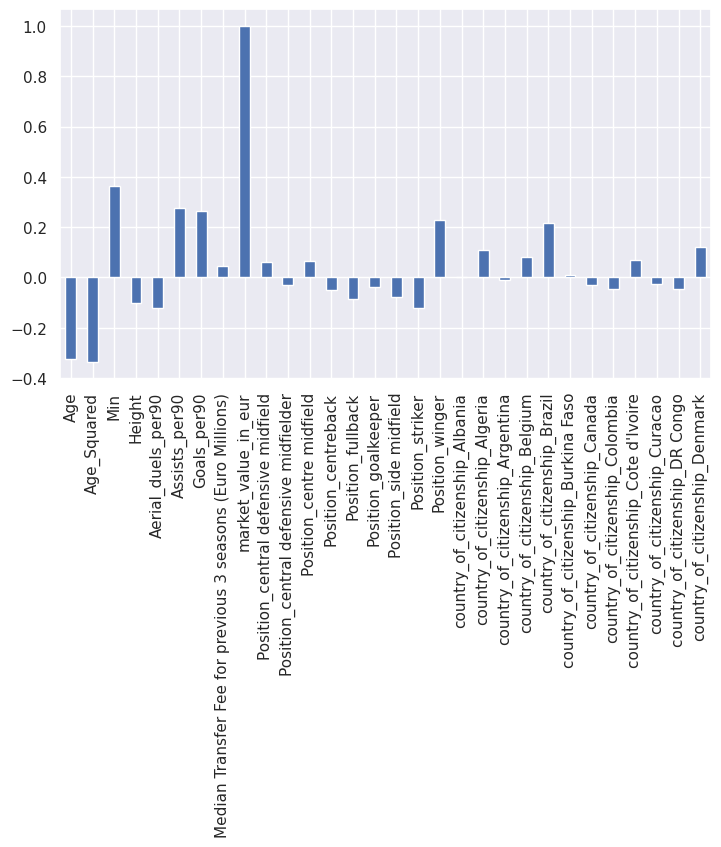

In [ ]:
finaldf.corr()["market_value_in_eur"][:30].plot(kind='bar')

<ipython-input-90-e4370cea067f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  finaldf.corr()["market_value_in_eur"][30:].plot(kind='bar')


<Axes: >

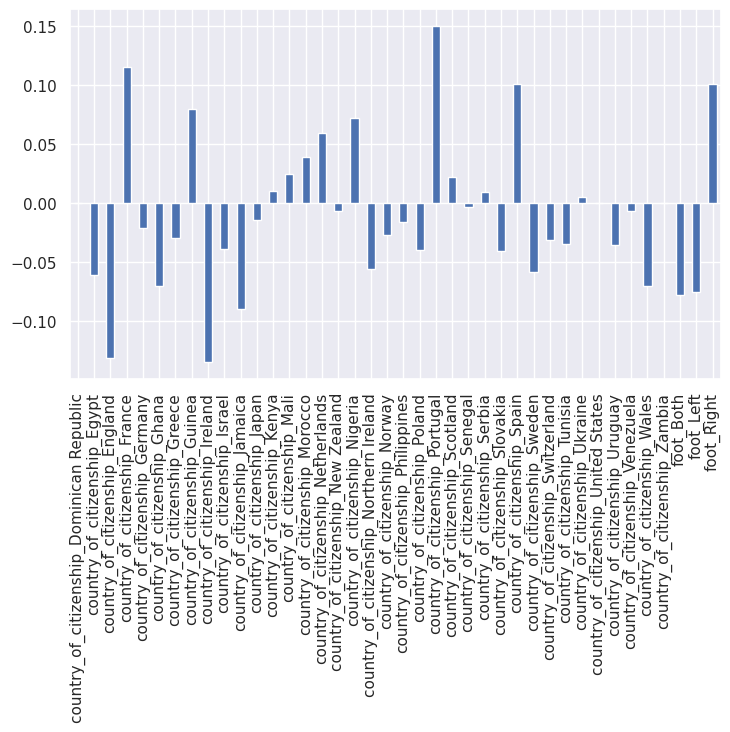

In [ ]:
finaldf.corr()["market_value_in_eur"][30:].plot(kind='bar')

Initial correlation plots suggest that the player's **age**, **number of minutes played**, as well as the **goal** and **assist** per 90 metrics are most strongly correlated with the value of the player. It is important to note the difference in axis for both these graphs as the top one has a higher magnitude of correlation compared to the ones at the bottom. Let's further explore the distribution split for each of these variables.

In [ ]:
finaldf['quantile'] = pd.qcut(finaldf['Age'], 4)

<ipython-input-92-446d90cdaeb1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = finaldf.groupby(by='quantile').mean()["market_value_in_eur"].plot.bar(x='Age Intervals', y='Mean Price')


Text(0, 0.5, 'Mean Price')

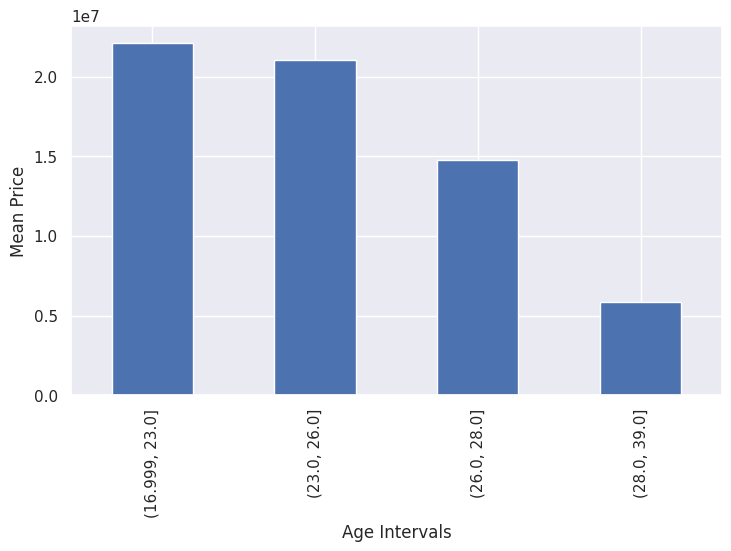

In [ ]:
ax = finaldf.groupby(by='quantile').mean()["market_value_in_eur"].plot.bar(x='Age Intervals', y='Mean Price')

ax.set_xlabel('Age Intervals')
ax.set_ylabel('Mean Price')

From the barplots above, we can clearly see that **older** players are generally priced **lower**. An empirical explanation for this preliminary observation would be that performance of players decline as they are older, and older players are possibly more susceptible to injuries than their younger counterparts, hence incurring **more risk** and **lower favourability** by football clubs. 

<ipython-input-93-84a225f20116>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = finaldf.groupby(by='quantile').mean()["market_value_in_eur"].plot.bar(x='Min Intervals', y='Mean Price')


Text(0, 0.5, 'Mean Price')

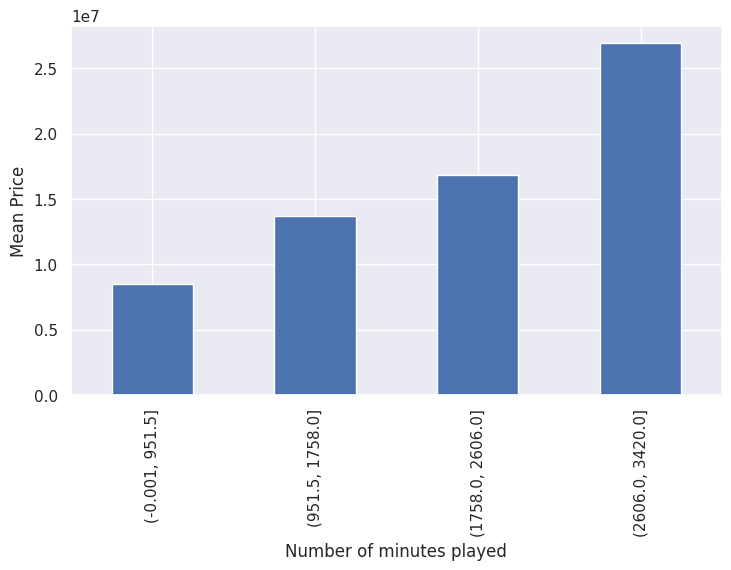

In [ ]:
finaldf['quantile'] = pd.qcut(finaldf['Min'], 4)
ax = finaldf.groupby(by='quantile').mean()["market_value_in_eur"].plot.bar(x='Min Intervals', y='Mean Price')

ax.set_xlabel('Number of minutes played')
ax.set_ylabel('Mean Price')

As we can see from the data above, players who **play more minutes across the season** are generally **valued higher**. An empirical explanation for this preliminary observation would be that football clubs generally field their strongest starting XI throughout the season, and hence better performing players play more minutes across the season. Hence, players who have played more minutes are better performers and are valued higher.

<ipython-input-94-2c25ff1244e4>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ast = finaldf.groupby(by='quantile').mean()["market_value_in_eur"]
<ipython-input-94-2c25ff1244e4>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  goals = finaldf.groupby(by='quantile').mean()["market_value_in_eur"]
<ipython-input-94-2c25ff1244e4>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(ast.index.astype(str), rotation=45)
<ipython-input-94-2c25ff1244e4>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(goals.in

[Text(0, 0, '(0.999, 240.5]'),
 Text(1, 0, '(240.5, 480.0]'),
 Text(2, 0, '(480.0, 719.5]'),
 Text(3, 0, '(719.5, 959.0]')]

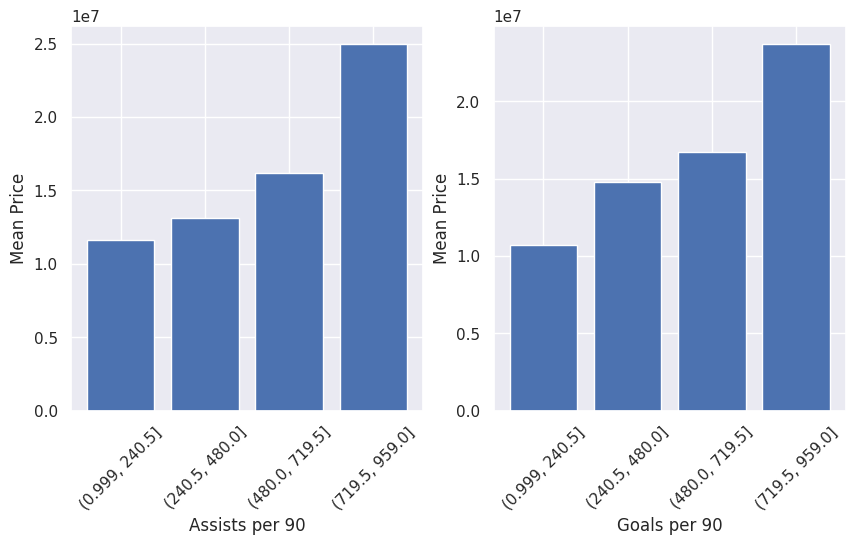

In [ ]:
finaldf['quantile'] = pd.qcut(finaldf['Assists_per90'].rank(method='first'), 4)
ast = finaldf.groupby(by='quantile').mean()["market_value_in_eur"]

finaldf['quantile'] = pd.qcut(finaldf['Goals_per90'].rank(method='first'), 4)
goals = finaldf.groupby(by='quantile').mean()["market_value_in_eur"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot the first barplot in the left subplot
axs[0].bar(ast.index.astype(str), ast.values)
axs[0].set_xlabel('Assists per 90')
axs[0].set_ylabel('Mean Price')
axs[0].set_xticklabels(ast.index.astype(str), rotation=45)

# plot the second barplot in the right subplot
axs[1].bar(goals.index.astype(str), goals.values)
axs[1].set_xlabel('Goals per 90')
axs[1].set_ylabel('Mean Price')
axs[1].set_xticklabels(goals.index.astype(str), rotation=45)


As we can see from the barplots above, players with **more assists and goals per 90** tend to have a **higher valuation**. This is congruent with our empirical understanding, whereby players who are more technically skilled and are able to contribute more to the team via goals and assists are valued at a higher price.

In [ ]:
finaldf = finaldf.drop(columns=['quantile'])

In [ ]:
# calculate the IQR
q1 = finaldf['market_value_in_eur'].quantile(0.25)
q3 = finaldf['market_value_in_eur'].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

<Axes: xlabel='market_value_in_eur', ylabel='Count'>

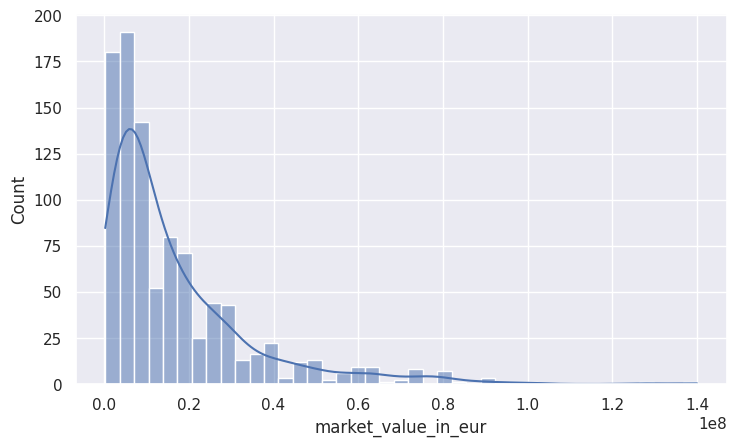

In [ ]:
sns.histplot(finaldf["market_value_in_eur"], kde=True)

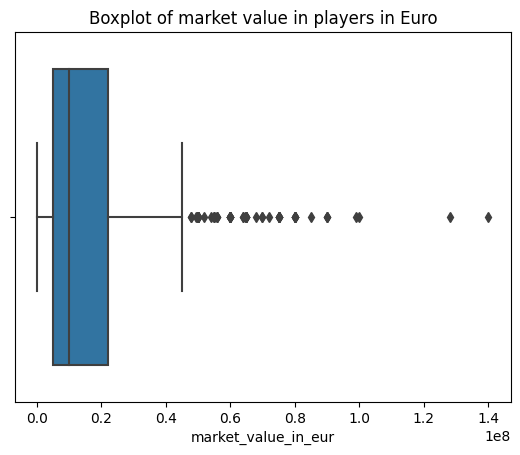

In [ ]:
ax = sns.boxplot(x=finaldf["market_value_in_eur"], orient='h').set_title('Boxplot of market value in players in Euro')


In [ ]:
outliers = [i for i in finaldf["market_value_in_eur"] if i > upper_bound or i< lower_bound]
len(outliers)

65

In [ ]:
print(f"Percentage of outliers is {len(outliers)/finaldf.shape[0] * 100}%")

Percentage of outliers is 6.777893639207508%


From the boxplot, kde and histogram plots above, we observe that this is a non-normal distribution which can be expected from a real world dataset. A positive skew indicates there is a wide range of market values for the top 50 percentile of palyers, indicating that clubs are willing to pay a huge premium the sign the most desired players. We have also realised that there are a handful of outliers with a high price range. Outliers can have a disproportionate impact on statistical measures such as the mean, which can be skewed or biased as a result. This can lead to incorrect conclusions and poor decision-making. Given that some of these players are estimated to be worth close to 100x the mean price, we theorise that it would not make sense to include these players as it would not be possible for them to acheive 100x the results of an average player. Hence we are removing these outlier data points

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
filtered_df = finaldf[(finaldf['market_value_in_eur'] > lower_bound) & (finaldf['market_value_in_eur'] < upper_bound)]

Text(0.5, 0, 'Market Value')

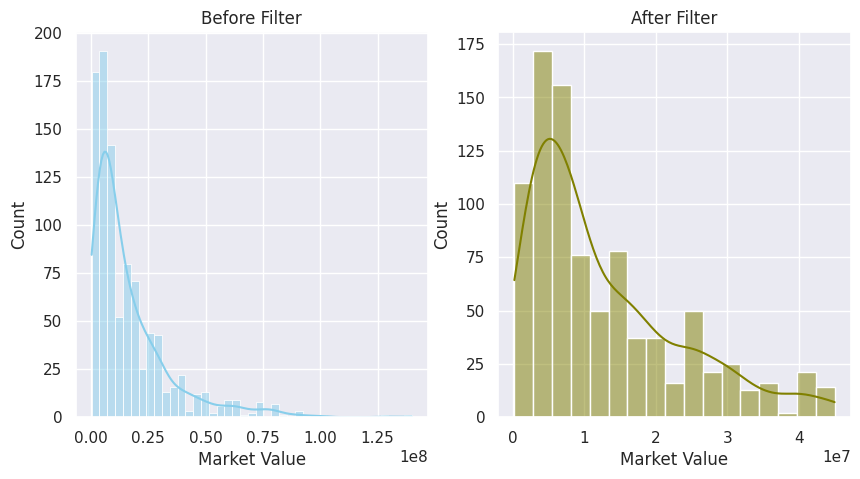

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0] = sns.histplot(ax=axs[0], data=finaldf, x='market_value_in_eur', color='skyblue', alpha=0.5, kde=True)
axs[0].set_title('Before Filter')
axs[0].set_xlabel('Market Value')

axs[1] = sns.histplot(ax=axs[1], data=filtered_df, x='market_value_in_eur', color='olive', alpha=0.5, kde=True)
axs[1].set_title('After Filter')
axs[1].set_xlabel('Market Value')

Text(0.5, 0, 'Market Value')

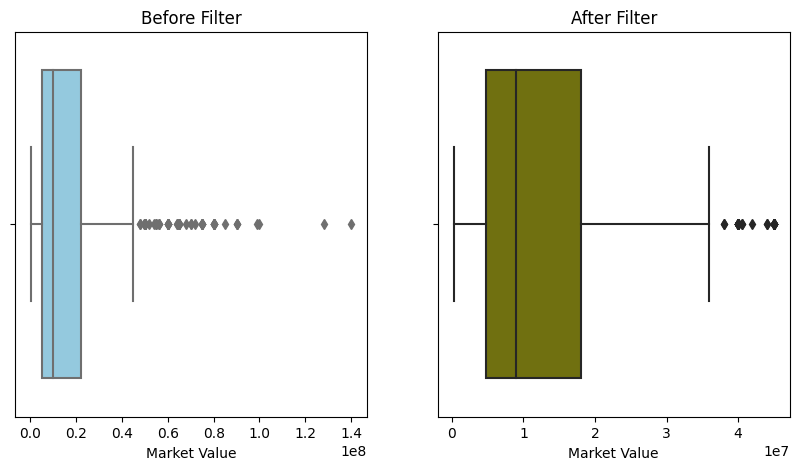

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0] = sns.boxplot(ax=axs[0], data=finaldf, x='market_value_in_eur', color='skyblue')
axs[0].set_title('Before Filter')
axs[0].set_xlabel('Market Value')

axs[1] = sns.boxplot(ax=axs[1], data=filtered_df, x='market_value_in_eur', color='olive')
axs[1].set_title('After Filter')
axs[1].set_xlabel('Market Value')

In [ ]:
filtered_df.to_csv("Data/final_list.csv")

Here we can see the effects of our outlier filtering. We have drastically reduced the number of outliers and our histogram and box plots indicate a general shift towards a normal distribution. Hopefully this can increase the accurancy of our predictions in the later portions.

# Section 5: Data Pre-Processing

In this section we have decided to split our data in an 80/20 split for training and testing purposes. We believe that this ratio trikes a balance between having enough data to train the model effectively and having enough data to evaluate its performance accurately. By keeping 20% of the data aside for testing, we can get a good estimate of the model's performance on unseen data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
finaldf = pd.read_csv("Data/final_list.csv", index_col=0)

In [ ]:
feats = finaldf.drop(columns=['Season', 'Name','Squad'])

In [ ]:
X = feats.drop(columns=['market_value_in_eur'])
y = feats['market_value_in_eur']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Additonally, we have also chosen to scale all our features using the MinMax Scaler. This scaler scales each feature to a range between 0-1 based on the minimum and maximum values of each feature. This normalises our data and ensure all features contribute equally to our model’s predictions regardless of initial values. They also preserve the distribution of the data which is crucial in our case since our data is a non-normal distribution.

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Section 6: Data Analysis Pipeline

In this section, we will be applying the data to each of the models we have chosen below and compare their outputs

- Choice of Models:
  - Random Forest Regressor: Builds multiple decisions trees and combines their predictions to make more accurate predictions. Useful when dealing with high-dimensional datasets and non-linear relationships between variables.
  - Support Vector Regressor: Finds a best-fit hyperplane that best represents the data points, with the goal of minimizing the error between the predicted and actual values. Useful when dealing with non-linear datasets
  - XGBoost (Gradient Boosting): Builds decision trees sequentially such that each new decision tree created corrects mistakes made by the previous. Capable of handling complex, nonlinear relationships between variables.
  - Artificial Neural Network: Makes use of multiple layers of neurons, with each neuron having an associated set of weights and biases. These weights and biases are updated for every batch of data fed in, via a technique known as backpropagation. 
- Explanation for choice of models:
  - Since our dataset comprises of many different factors with yet unknown relationship with the player's Current Valuation, we deliberately chose models that are capable of dealing with the large number of factors and non-linear relationships. This is in comparison to using models that assume linear relationships, such as Linear Regression.
  - In addition, the models were chosen as they function on different fundamental principles, to provide a range of different regressions paradigms. By using range of models, we hoped to be able to find the best performing one.
  
  
**For each of our models, the multi-variate inputs that are provided will be all features from their age to their preferred foot as well as the true market value which was obtained from kaggle. Our outputs that are expected would be an estimated market valuation for each player that will be passed through the model**

## Section 6.1: Artificial Neural Network

An ANN typically consists of an input layer, one or more hidden layers, and an output layer. The input layer takes in the raw data, which is then passed through the hidden layers to the output layer. Each hidden layer consists of a number of neurons, which are interconnected to each other and to the neurons in the adjacent layers. The weights of the connections between neurons are adjusted during the training process, to optimize the performance of the network

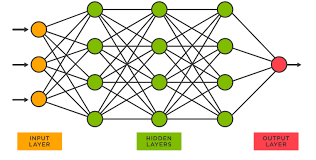

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

Tuning hyperparameters is a critical step in building machine learning models that achieve optimal performance. One way to automate this process, and the way that we have proceed with, is to use scikit-learn's GridSearchCV API. This API  exhaustively searches over a range of hyperparameter values to find the combination that yields the best cross-validation score. This can save significant time and effort compared to manually tuning hyperparameters. 

These hyperparameters are:
- num_hidden_layers = 2
- num_epochs = 2000 with early stopping
- No. of dense units = 68,32,8,1
- batch_size = 32

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)


In [ ]:
model = Sequential()
model.add(Dense(68,activation='relu')) # Change to input feature number
model.add(Dense(32,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=32,epochs=2000,callbacks=[early_stop])

Epoch 1/2000
24/24 [==============================] - 1s 11ms/step - loss: 568538242744320.0000 - val_loss: 665272516083712.0000
Epoch 2/2000
24/24 [==============================] - 0s 3ms/step - loss: 568538242744320.0000 - val_loss: 665272381865984.0000
Epoch 3/2000
24/24 [==============================] - 0s 3ms/step - loss: 568537907200000.0000 - val_loss: 665271844995072.0000
Epoch 4/2000
24/24 [==============================] - 0s 4ms/step - loss: 568537236111360.0000 - val_loss: 665270637035520.0000
Epoch 5/2000
24/24 [==============================] - 0s 3ms/step - loss: 568535692607488.0000 - val_loss: 665268019789824.0000
Epoch 6/2000
24/24 [==============================] - 0s 3ms/step - loss: 568532471382016.0000 - val_loss: 665263120842752.0000
Epoch 7/2000
24/24 [==============================] - 0s 3ms/step - loss: 568526834237440.0000 - val_loss: 665254866452480.0000
Epoch 8/2000
24/24 [==============================] - 0s 4ms/step - loss: 568518042976256.0000 - val_lo

<Axes: >

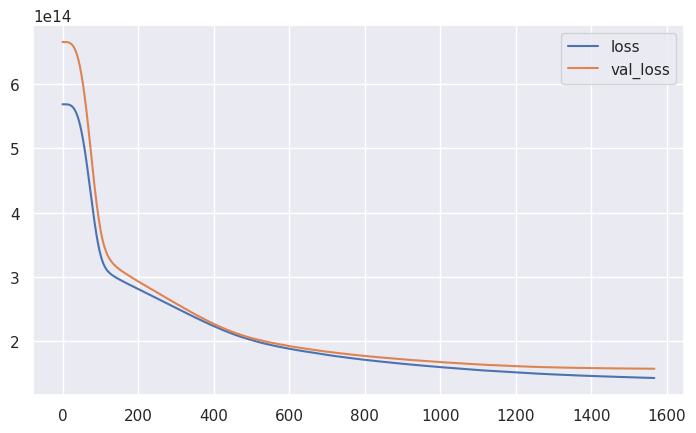

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

The plot above shows the training loss and validation loss for the Artificial Neural Network, for each training epoch. Both values converge to a minimum, and the artificial neural network is not overfitted.

## Section 6.2: Model Evaluation for ANN

In evaluating our models we use 3 different metrics namely:

- **Root mean squared error**
- **Mean absolute error**
- **R^2**


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
predictions = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


Root mean squared error (RMSE) is a commonly used metric to evaluate the performance of a regression model. It is calculated as the square root of the mean of the squared differences between predicted and true values of the target variable. The formula for RMSE is:

RMSE = sqrt(1/n * Σ(yi - ŷi)²)

Where:

n is the total number of samples
yi is the true value of the target variable for sample i
ŷi is the predicted value of the target variable for sample i

Unlike some other metrics that only provide information about the direction of the errors (i.e., whether they are positive or negative), RMSE provides information about the magnitude of the errors. This can be useful in our application as we are looking at player valuation and thus need to know in greater detail about the error from the model rather than if it is just higher or lower than the true value

In [ ]:
#RMSE
np.sqrt(mean_squared_error(y_test,predictions))

12553919.349391129

Mean Absolute Error (MAE) is a commonly used metric to evaluate the performance of regression models. It measures the average absolute difference between the predicted and actual values of the target variable. The formula for MAE is:

MAE = 1/n * Σ|yi - ŷi|

Where:

n is the total number of samples
yi is the true value of the target variable for sample i
ŷi is the predicted value of the target variable for sample i

This is because RMSE is more sensitive to outliers because it squares the differences between predicted and actual values. This means that it gives more weight to larger errors, which can be problematic if there are outliers in the dataset. MAE treats all errors equally, regardless of their magnitude, which can make it more robust to outliers, making it useful failsafe in the case where we discover that we still have too many outliers in our dataset.

In [ ]:
#MAE
mean_absolute_error(y_test,predictions)

7906289.080240886

R-squared (R²) is a statistical metric that measures the proportion of variation in the target variable that is explained by the regression model. It is also known as the coefficient of determination. R² values range from 0 to 1, with a value of 1 indicating that the model explains all the variability in the target variable and a value of 0 indicating that the model explains none of the variability.

R² is a good indicator for our project due to it being a bounded and standardized measure, which makes it easy to interpret as we can easily tell at first glance which model outperforms the other. If we were to instead compare between RMSE or MAE, the results could be in differing magnitudes and we would additionally have to look a the true market value for each player to determine the accuracy of the model. Thus R² can be used to compare the performance of different models and select the one that performs the best. 

In [ ]:
#R^2
r2_score(y_test, predictions)

0.5193627885973837

## Section 6.3: Random Forest Regressor

Random Forest is a machine learning algorithm that is used for classification and regression tasks. It is an ensemble learning method that creates a large number of decision trees and aggregates their predictions to obtain a final output.

The Random Forest algorithm works as follows:

- A random subset of the training data is selected to train each decision tree. This subset is known as the bootstrap sample. This is done to introduce randomness into the model and reduce the chance of overfitting.

- A decision tree is created using the bootstrap sample. The tree is grown by recursively splitting the data based on the feature that provides the best split. The best split is determined by maximizing the information gain or minimizing the impurity in the nodes.

- The above steps are repeated to create a large number of decision trees. The number of trees is a hyperparameter that can be tuned to improve the model's performance.

- During the prediction phase, each decision tree in the forest makes a prediction. The final output is obtained by aggregating the predictions of all the decision trees. In case of classification, the mode of the predicted classes is taken as the final output. In case of regression, the average of the predicted values is taken as the final output.


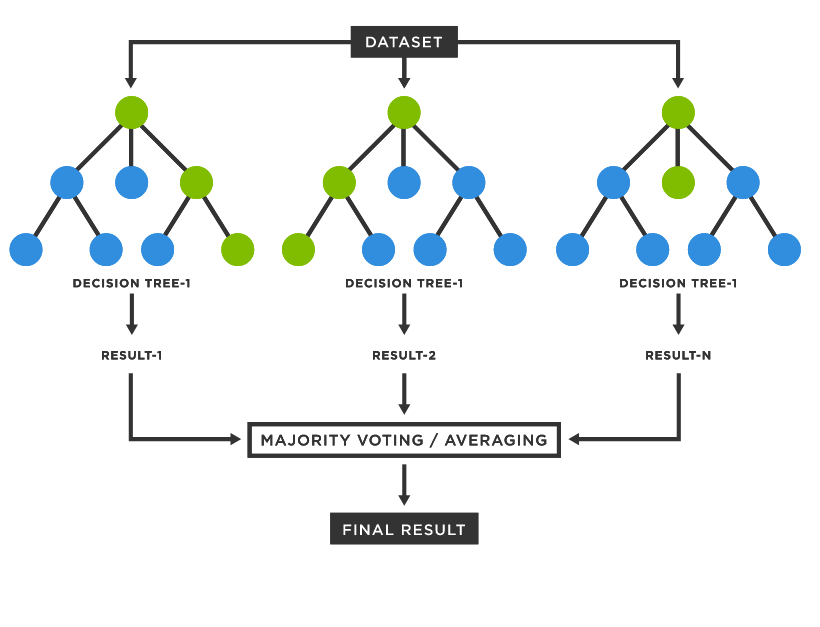


The hyperparameters for this model are:
- No. of trees:	100
- Max Depth:	None
- Min Samples Split:	2
- Min Samples to be a leaf node:	1


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
# Train the model on training data
rf.fit(X_train, y_train)

## Section 6.4: Model Evaluation for RFR

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

In [ ]:
#RMSE
np.sqrt(mean_squared_error(y_test, predictions))

6637550.86136075

In [ ]:
#MAE
mean_absolute_error(y_test, predictions)

4269030.726256983

In [ ]:
#R^2
r2_score(y_test, predictions)

0.6451296341526775

## Section 6.5: Support Vector Regressor

Support Vector Regression (SVR) is a supervised machine learning algorithm that can be used for regression tasks. It works by finding a hyperplane in a high-dimensional space that best fits the training data. This hyperplane is used to make predictions on the test data.

SVR works by constructing a set of support vectors which define the hyperplane. These support vectors are the data points that lie closest to the hyperplane. The algorithm then finds the hyperplane that maximizes the distance between these support vectors and the hyperplane.The objective of SVR is to minimize the error between the predicted output and the actual output. In order to do this, the algorithm uses a loss function that penalizes the distance between the predicted output and the actual output. 

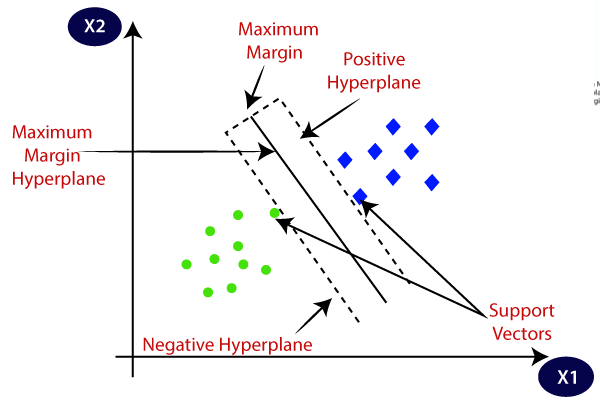

The hyperparameters for this model are:
- Kernel: "rbf"
- Gamma: "scale"

In [ ]:
y_scaled = y.values.reshape(len(y),1)

In [ ]:
_, _, y_train_scaled, y_test_scaled = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

In [ ]:
yscaler = MinMaxScaler()
y_train_scaled = yscaler.fit_transform(y_train_scaled)
y_test_scaled = yscaler.transform(y_test_scaled)

In [ ]:
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf', gamma='scale')
regressor.fit(X_train, y_train_scaled)

SVR()

## Section 6.6: Evaluation of SVR

In [ ]:
predictions = regressor.predict(X_test)
predictions = predictions.reshape(-1,1)
predictions = yscaler.inverse_transform(predictions)

In [ ]:
predictions = predictions.flatten()

In [ ]:
#RMSE
np.sqrt(mean_squared_error(y_test, predictions))

12927426.58584882

In [ ]:
#MAE
mean_absolute_error(y_test, predictions)

9819964.103273626

In [ ]:
#R^2
r2_score(y_test, predictions)

0.4903372620451393

## Section 6.7: XGBoost

Gradient boosting is a technique for building ensemble models that combine multiple weak models into a strong predictive model. XGBoost specifically uses a gradient boosting approach that involves iteratively training a series of decision trees, each one attempting to correct the errors of the previous tree.

XGBoost includes a number of features that make it particularly effective, such as a built-in regularization technique to prevent overfitting, and the ability to handle missing data.

The steps for XGBoost are as follows:

- Initialization: XGBoost starts with a single decision tree as the base model. The base model makes predictions based on the input features, and the model's performance is evaluated using a loss function (e.g., mean squared error for regression problems or log loss for binary classification).

- Boosting: XGBoost iteratively adds decision trees to the model to improve its accuracy. In each iteration, the algorithm calculates the gradient of the loss function with respect to the predictions made by the current model. This gradient information is used to fit a new decision tree that predicts the residual errors of the current model.

- Regularization: To prevent overfitting, XGBoost uses a variety of regularization techniques. One such technique is called "L1 regularization" (also known as Lasso regularization), which adds a penalty to the loss function based on the absolute value of the weights in the model. Another technique is called "L2 regularization" (also known as Ridge regularization), which adds a penalty to the loss function based on the square of the weights in the model.

- Prediction: Once all the decision trees have been added to the model, XGBoost combines their predictions to make a final prediction. The final prediction is the sum of the predictions made by each decision tree, weighted by a shrinkage parameter (also known as the learning rate).

- Optimization: XGBoost includes a number of features to optimize the training process, such as early stopping and cross-validation. Early stopping stops the training process if the model's performance on a validation set does not improve for a certain number of iterations. Cross-validation helps to find the optimal values for hyperparameters like the learning rate and regularization strength.

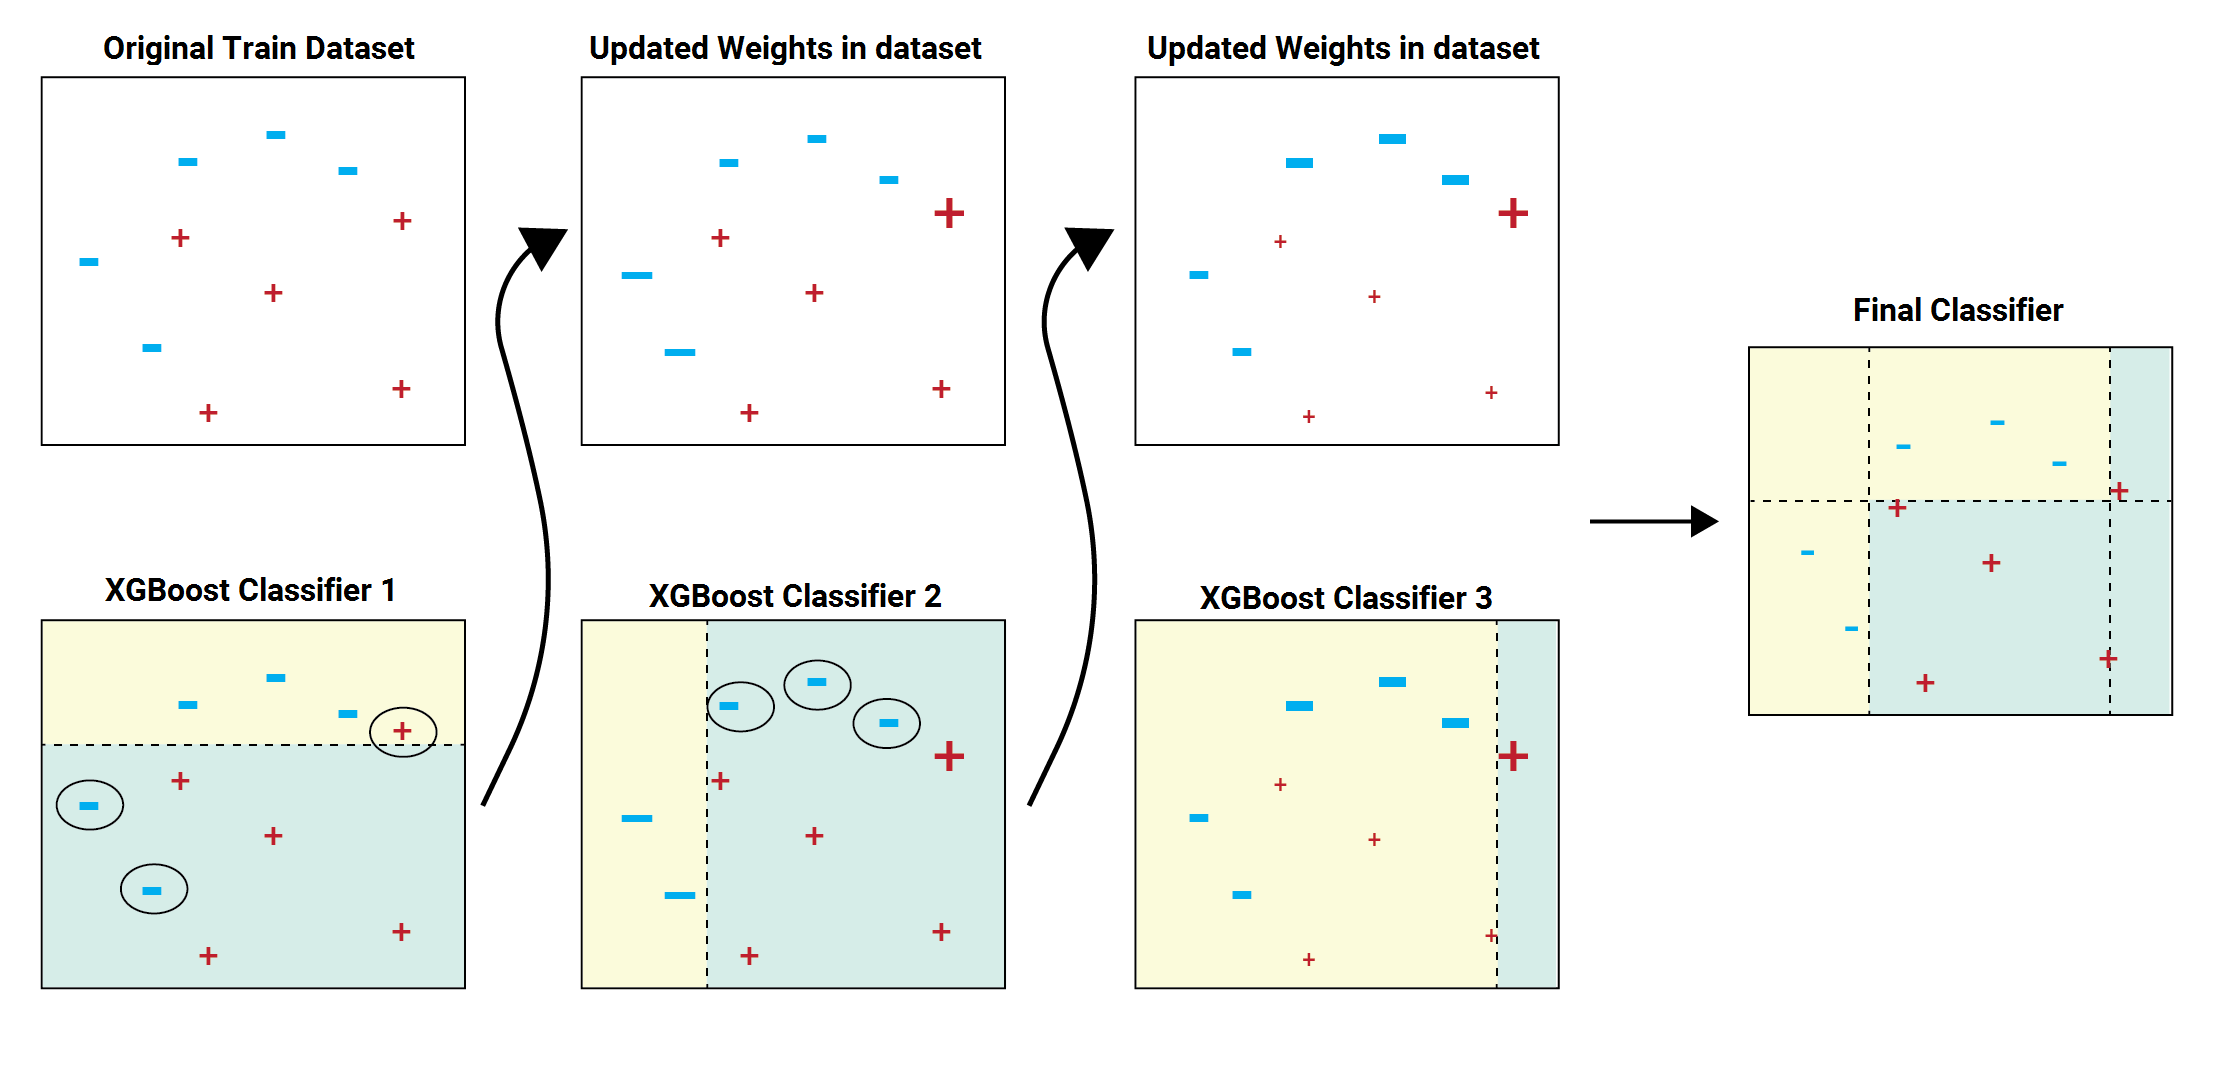


The hyperparameters are:

- No. of trees:	1000
- Gamma:	0
- Max Depth:	4
- Colsample Bytree:	0.7
- Learning Rate:	0.1


In [ ]:
import xgboost as xgb

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgbr = xgb.XGBRegressor(
    n_estimators = 1000,
    reg_lambda = 1,
    gamma = 0,
    max_depth = 4,
    colsample_bytree = 0.7,
    min_child_weight = 5,
    learning_rate = 0.1,
    random_state=42
)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

## Section 6.8: Evaluation of XGBoost

In [ ]:
y_pred = xgbr.predict(X_test)

In [ ]:
#RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

5686659.132521033

In [ ]:
#MAE
mean_absolute_error(y_test, y_pred)

3404561.38547486

In [ ]:
#r^2
r2_score(y_test, y_pred)

0.7395235863054019

| Model                     | RMSE        | MAE         | R^2         |
| ------------------------- | ----------- | ----------- | ----------- |
| Artificial Neural Network | 12553919.35 | 7906289.08  | 0.51936279  |
| Random Forest Regressor   | 6637550.86  | 4269030.73  | 0.64512963  |
| Support Vector Regressor  | 12927426.59 | 9819964.10  | 0.49033726  |
| XGBoost                   | 5686659.133 | 3404561.39  | 0.73952359  |


In our case, as we have a number of models to choose from, the baseline that we are choosing is to compare the models amongst each other to determine the most accurate market valuation of a player and comparing it with the actual valuation of the data which was scrapped from FBref and transfermkt.

As seen from the results as compiled in the table above, across all error (RMSE, MAE) and R^2 metrics, both XGBoost and Random Forest Regressor fare much better and are a closer fit and capturing the underlying patterns better than the other regression counterparts.


Our conclusion is held in a statistical sense, based on the results of our model evaluation and comparison. We used objective metrics to evaluate the performance of our model and compared it amongst each other and with the true market value to ensure that our conclusions were robust. We also conducted a thorough hyperparameter tuning process to select the best configuration for our model. Of course, the underlying assumption here is that the market value which have scrapped online are true representations of the market value of the player. Additonally, we have also assumed that the data set which we have scrapped for the model training is a good representative of the population that we are trying to model and that there is no significant bias or sampling error in the data

A possible reason for the worse performance of the ANN and SVR could have been the lack of hyperparameter tuning. In the case of the ANN, many hyperparameters such as the number of hidden layers and kernel initialisers dictating the training and fundamental structure of the model were not optimised. In the case of the SVR, hyperparameters such as the kernel and gamma were not optimised, in the interest of time.

For the following model application portion, we decided to **scope down the models to just the Random Forest Regressor, and the XGBoost model**.

# Section 7: Model Application

In this section, we apply the XGBoost and RFR models on transfer targets of Manchester United. As the current 2022/2023 season is still ongoing, we decided to feed in the 2021/2022 statistics of these transfer targets.

The list of transfer targets are:
- Harry Kane
- Moises Caiceido
- Alexis Mac Allister
- David Raya
- James Ward-Prowse



In [ ]:
target_df = pd.read_csv("Data/manu_target.csv", index_col=0)
target_df = target_df[target_df['Season'].str[:4].astype(int) == 2021]

In [ ]:
median_fees = pd.read_csv("Data/median_transfer_fees.csv", index_col=0)
median_fees.head()

,Current Season,Club Name,Median Transfer Fee for previous 3 seasons (Euro Millions)
0,2017/2018,AFC Bournemouth,3.5
1,2017/2018,Arsenal FC,14.0
2,2017/2018,Aston Villa,3.8
3,2017/2018,Brighton & Hove Albion,0.4
4,2017/2018,Burnley FC,10.8


In [ ]:
club_mappings = {
    "Wolves": "Wolverhampton Wanderers",
    "Sheffield Utd": "Sheffield United",
    "Everton": "Everton FC",
    "Southampton": "Southampton FC",
    "West Brom": "West Bromwich Albion",
    "Arsenal": "Arsenal FC",
    "Fulham": "Fulham FC",
    "West Ham": "West Ham United",
    "Huddersfield": "Huddersfield Town",
    "Tottenham": "Tottenham Hotspur",
    "Watford": "Watford FC",
    "Newcastle Utd": "Newcastle United",
    "Chelsea": "Chelsea FC",
    "Manchester Utd": "Manchester United",
    "Liverpool": "Liverpool FC",
    "Bournemouth": "AFC Bournemouth",
    "Brighton": "Brighton & Hove Albion",
    "Burnley": "Burnley FC",
    "Brentford": "Brentford FC",
    "Nott'ham Forest": "Nottingham Forest"
}

In [ ]:
# Merging Median Transfer Fee & Player Season Stats Dataframes
target_df["Squad"] = target_df["Squad"].replace(club_mappings)
median_fees["Current Season"] = median_fees["Current Season"].str.replace("/", "-")
target_df = target_df.merge(median_fees, left_on=['Squad', 'Season'], right_on=['Club Name', 'Current Season'], how='left')

In [ ]:
position_mappings = {
    " FW-MF (AM-DM)": "centre midfield",
    " MF (DM, left)": "central defensive midfield",
    " DF-MF (DM-FB-WM, left)": "fullback",
    " MF (CM-DM-WM)": "centre midfield",
    " FW-MF (AM-WM)": "winger",
    " GK": "goalkeeper",
    " FW-MF (WM)": "striker",
    " DF-MF (FB, right)": "fullback",
    " FW": "striker",
    " DF-FW-MF (FB-WM, right)": "fullback",
    " DF-MF (FB-WM, right)": "fullback",
    " FW-MF": "striker",
    " DF-MF (CB-DM, right)": "centreback",
    " DF-FW-MF (AM-FB, left)": "fullback",
    " FW-MF (AM-WM, right)": "winger",
    " DF (CB)": "centreback",
    " DF-MF (CB-CM, left)": "centreback",
    " DF (FB, left)": "fullback",
    " MF (CM)": "centre midfield",
    " DF (CB, left)": "centreback",
    " DF-FW-MF": "winger",
    " DF-MF (FB, left)": "fullback",
    " MF (AM-CM-WM)": "centre midfield",
    " DF-MF (CM-DM-WM, left)": "centre midfield",
    " FW-MF (AM)": "winger",
    " DF-MF (CM-DM)": "central defensive midfield",
    " DF (CB-FB, left)": "centreback",
    " MF (AM-CM-DM-WM)": "centre midfield",
    " DF-MF (CB)": "centreback",
    " DF (FB, right)": "fullback",
    " DF-MF (CB-DM)": "centreback",
    " MF (AM)": "centre midfield",
    " DF-FW-MF (WM, left)": "side midfield",
    " DF (CB-FB)": "centreback",
    " DF-MF (CB, right)": "centreback",
    " FW-MF (WM, right)": "winger",
    " DF-MF": "fullback",
    " DF-MF (CM-DM, right)": "centre midfield",
    " MF": "centre midfield",
    " MF (CM-DM)": "central defensive midfield",
    " DF (CB-FB, right)": "centreback",
    " DF-MF (AM-WM, left)": "centre midfield",
    " DF-MF (CB-FB, right)": "fullback",
    " MF (AM-CM-DM)": "centre midfield",
    " DF-FW (FB, right)": "fullback",
    " MF (CM-WM, right)": "centre midfield",
    " DF-MF (CB-CM-DM)": "central defensive midfield",
    " MF (AM-CM, right)": "centre midfield",
    " FW-MF (WM, left)": "winger",
    " FW-MF (AM-CM-WM)": "centre midfield",
    " DF (CB, right)": "centreback",
    " FW-MF (AM, left)": "winger",
    " FW-MF (AM-WM, left)": "winger",
    " DF-MF (CB-FB, left)": "centreback",
    " DF-FW-MF (FB-WM)": "fullback",
    " MF (CM-WM)": "centre midfield",
    " DF-MF (CM-DM-FB-WM, right)": "centre midfield",
    " DF-FW-MF (FB)": "fullback",
    " FW-MF (AM-CM-DM)": "centre midfield",
    " MF (AM-WM)": "centre midfield",
    " DF-FW-MF (WM)": "side midfield",
    " DF-MF (FB-WM, left)": "fullback",
    " DF-MF (CM-FB-WM)": "centre midfield",
    " MF (CM, right)": "centre midfield",
    " DF-FW-MF (FB-WM, left)": "fullback",
    " DF-MF (DM-FB, left)": "fullback",
    " DF-MF (DM-FB, right)": "fullback",
    " MF (CM, left)": "centre midfield",
    " DF": "fullback",
    " FW-MF (AM-CM-DM, left)": "centre midfield",
    " DF-FW-MF (AM-DM-WM, right)": "side midfield",
    " MF (WM)": "centre midfield",
    " FW-MF (AM-CM, right)": "winger",
    " DF-MF (CB, left)": "centreback",
    " MF (DM)": "central defensive midfield",
    " FW-MF (CM-WM)": "centre midfield",
    " DF-MF (CM-DM-FB)": "central defensive midfield",
    " MF (DM, right)": "central defensive midfield",
    " FW-MF (CM)": "centre midfield",
    " DF-FW-MF (AM-WM)": "side midfield",
    " FW-MF (AM-CM)": "centre midfield",
    " DF-MF (CM)": "central defensive midfielder",
    " DF-FW-MF (AM, left)": "side midfield",
    " MF (AM-DM-WM)": "centre midfield",
    " DF-FW (CB, right)": "centreback",
    " MF (AM-CM-DM, right)": "centre midfield",
    " DF-MF (DM)": "central defensive midfielder",
    " DF-FW-MF (AM-CM-FB-WM)": "fullback",
    " DF (FB)": "fullback",
    " DF-MF (CB-FB-WM, left)": "centreback"
}

In [ ]:
# Simplifying Player Positions for easier training

target_df["Position"] = target_df["Position"].replace(position_mappings)
target_df["Position"] = target_df["Position"].astype("category")

In [ ]:
target_df["Median Transfer Fee for previous 3 seasons (Euro Millions)"] = target_df["Median Transfer Fee for previous 3 seasons (Euro Millions)"].fillna(0)

In [ ]:
feats = target_df.drop(columns=['Season', 'Name','Squad','League', 'Current Season', 'Club Name'])

In [ ]:
# Converting player height into a numerical entry

feats["Height"] = feats["Height"].str.rstrip("cm")
feats["Height"] = feats["Height"].astype(float)

In [ ]:
# Converting citizenship and foot into categorical variables

feats["country_of_citizenship"] = feats["country_of_citizenship"].astype("category")
feats["foot"] = feats["foot"].astype("category")

In [ ]:
# One hot encoding of Position, Citizenship and Foot data
feats = pd.get_dummies(feats, columns=['Position', 'country_of_citizenship', 'foot'])

In [ ]:
feats = feats.reindex(columns=X.columns).fillna(0)

In [ ]:
X_scaled = scaler.transform(feats)

In [ ]:
rf_predictions = rf.predict(X_scaled)
xg_predictions = xgbr.predict(feats)

In [ ]:
target_df["rf_predictions"] = rf_predictions
target_df["xg_predictions"] = xg_predictions

In [ ]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 19 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   Season                                                      5 non-null      object  
 1   Name                                                        5 non-null      object  
 2   Age                                                         5 non-null      int64   
 3   Age_Squared                                                 5 non-null      int64   
 4   Min                                                         5 non-null      int64   
 5   Height                                                      5 non-null      object  
 6   Position                                                    5 non-null      category
 7   Aerial_duels_per90                                          5 non-null      float64 

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
filtered_df = target_df[["Season", "Name", "Squad", "rf_predictions", "xg_predictions"]]
filtered_df.sort_values(by='rf_predictions')

,Season,Name,Squad,rf_predictions,xg_predictions
4,2021-2022,David Raya,Brentford FC,8262000.00,8838544.00
2,2021-2022,Alexis Mac Allister,Brighton & Hove Albion,9808000.00,18726884.00
1,2021-2022,Moisés Caicedo,Brighton & Hove Albion,12949000.00,4082235.75
0,2021-2022,Harry Kane,Tottenham Hotspur,17618000.00,24064912.00
3,2021-2022,James Ward-Prowse,Southampton FC,25545000.00,22507184.00


In [ ]:
filtered_df.sort_values(by='xg_predictions')

,Season,Name,Squad,rf_predictions,xg_predictions
1,2021-2022,Moisés Caicedo,Brighton & Hove Albion,12949000.00,4082235.75
4,2021-2022,David Raya,Brentford FC,8262000.00,8838544.00
2,2021-2022,Alexis Mac Allister,Brighton & Hove Albion,9808000.00,18726884.00
3,2021-2022,James Ward-Prowse,Southampton FC,25545000.00,22507184.00
0,2021-2022,Harry Kane,Tottenham Hotspur,17618000.00,24064912.00


Looking at the predictions from both the Random Forest Regressor and XGBoost model, the player valuations generated for *David Raya* and *James Ward-Prowse* are relatively similar, while there exists some disparity for the values generated for *Moisés Caicedo*, *Alexis Mac Allister* and *Harry Kane*.

Based on empirical information and observations from the 2021/2022 season, the predictions generated by the XGBoost model seems to make more sense, while the predictions generated by the Random Forest Regressor seems to be more conservative on the player valuations. 

# Section 8: Conclusion

In our analysis, we used a total of **4** different machine learning and data science models. They include:

1. Artificial Neural Network
2. Random Forest Regressor
3. Support Vector Regressor
4. XGBoost

Of all 4 models, we found the **RFR and XGBoost models** to be the most performant. 

With both RFR and XGBoost models, we've successfully come up the estimated valuations of Manchester United's transfer targets, based on their 2021/2022 stats.

| Transfer Targets          | RFR Player Valuation     | XGBoost Player Valuation     |
| ------------------------- | ------------------------ | ------------------------ |
| Moisés Caicedo	          | 12949000.00              | 4082235.75   |
| David Raya	              | 8262000.00	             | 8838544.00   |
| Alexis Mac Allister       | 9808000.00               | 18726884.00  |
| James Ward-Prowse         | 25545000.00              | 22507184.00  |
| Harry Kane	              | 17618000.00              | 24064912.00  |



Some limitations of our current model are how we are only consider a player's individual performance on the pitch rather than his holistic performance on at a team level. Certain skills such as player movements and off the ball contribution are crucial to a footballer's gameplay and can be captured using real life footage and with the help of image recognition technology. 

Another assumption that was made during for this model was that a player's valuation is based soley on his on pitch performance. . In the real world, there are many interdisciplinary factors which can affect the player’s market value such as their public image and marketing value which can be capitalised on by the purchasing club for monetary value. These data such as number of endorsements and social media pull could be included in future iterations of this project to more accurately determine the price a club should consider paying.